# MULTI-CONTROLLED $U$ GATES

## Goal of the project.

Write a Qiskit function that takes two inputs: a positive integer $n$ and a matrix $U \in U(2)$ and outputs a quantum circuit on $n + 1$ qubits, possibly with further ancillas, that implements a multi-controlled $U$ gate, $C^nU$, that is
$$
C^n U \ket{x}_n \ket{y}_1 = 
\begin{cases}
\ket{x}_n U \ket{y}_1 \quad &\text{if } \, x = (1, 1, \dots, 1), \\
\ket{x}_n \ket{y}_1 \quad &\text{otherwise.}
\end{cases}
$$
The construction is to consist of arbitrary $1$-qubit gates ([$U$ gate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UGate)) and $CX$ gates, but no classical bits or measurements. 




Let us import the necessary packages first, and set parameters Theta, Phi, Lam which will determine $U$.

In [127]:
pip install qiskit numpy

Note: you may need to restart the kernel to use updated packages.


In [128]:
# Import packages 

from qiskit import quantum_info 
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UGate
from qiskit import transpile

import numpy as np

In [129]:
# Define Parameters 

Theta, Phi, Lam = Parameter(r"$\theta$"), Parameter(r"$\varphi$"), Parameter(r"$\lambda$")

We assume that the matrix $U$ is provided by a $2\times 2$ numpy array. The function will determine the values of $\theta, \varphi, \lambda$ from entries of $U$ step-by-step.

The result of our discussion below will be the following function. The circuit constructed is based on Corollary 4.2 of Nielsen and Chuang's _Quantum Computing and Quantum Information_ book. 

In [130]:
def multi_controlled(n, U):

# Check that n is a positive integer    
    
    if type(n) != int or n <= 0:
        return False

# Check that U is 2 by 2 unitary
    
    if np.absolute(U[0,0]) != np.absolute(U[1,1]) or np.absolute(U[0,1]) != np.absolute(U[1,0]):
        return False
    
    if U.shape != (2, 2):
        return False

# Determine Theta, Phi and Lam from entries of U
    
    if np.isreal(U[0,0]) == True and -1<= U[0,0] <=1: 
        Theta = 2*np.arccos(U[0, 0])
        if np.sin(Theta/2) != 0:
            Lam = np.angle(-U[0, 1]/(np.sin(Theta/2)))
            Phi = np.angle(U[1, 0]/(np.sin(Theta/2)))
        else: 
            Phi = 0
            if U[0,1] != 0 or U[1,0] != 0:
                return False
            if U[0,0] == 0:
                return False   
            elif U[0,0] != 0:   
                Lam = U[1,1]/U[0,0]   

# Define the circuit that produces a Toffoli gate
    toffoli_register = QuantumRegister(3, "t")
    toffoli_circuit = QuantumCircuit(toffoli_register)
    
    toffoli_circuit.h(toffoli_register[2])
    toffoli_circuit.cx(toffoli_register[1], toffoli_register[2])
    toffoli_circuit.tdg(toffoli_register[2]) # tdg is the method for the inverse of T
    toffoli_circuit.cx(toffoli_register[0], toffoli_register[2])
    toffoli_circuit.t(toffoli_register[2])
    toffoli_circuit.cx(toffoli_register[1], toffoli_register[2])
    toffoli_circuit.tdg(toffoli_register[2])
    toffoli_circuit.cx(toffoli_register[0], toffoli_register[2])
    toffoli_circuit.t(toffoli_register[2])
    toffoli_circuit.h(toffoli_register[2])
    toffoli_circuit.cx(toffoli_register[0], toffoli_register[1])
    toffoli_circuit.tdg(toffoli_register[1])
    toffoli_circuit.cx(toffoli_register[0], toffoli_register[1])
    toffoli_circuit.t(toffoli_register[0])
    toffoli_circuit.t(toffoli_register[1])
        

# Handle the case n=1 
    if n == 1: 
        quantum_register = QuantumRegister(size=2, name="q")
        c_n_u_circuit = QuantumCircuit(quantum_register)
        # apply C
        c_n_u_circuit.rz((Lam-Phi)/2,quantum_register[1])
        # apply control gate
        c_n_u_circuit.cx(quantum_register[0],quantum_register[1])
        # apply B
        c_n_u_circuit.rz((-Lam-Phi)/2,quantum_register[1])
        angle = (-Theta / 2).real
        c_n_u_circuit.ry(angle,quantum_register[1])
        # apply control gate
        c_n_u_circuit.cx(quantum_register[0],quantum_register[1])
        # apply A
        c_n_u_circuit.ry(-angle,quantum_register[1])
        c_n_u_circuit.rz(Phi,quantum_register[1])
        # apply phase gate to qubit zero
        c_n_u_circuit.p((-Lam-Phi)/2, quantum_register[0])
    
# Handle the case n>1 
    if n >= 2: 
        quantum_register = QuantumRegister(n, name = "c")
        ancilla_register = AncillaRegister(n-1, name = "a")
        target_register = QuantumRegister(1, name = "t")
        c_n_u_circuit = QuantumCircuit(quantum_register, ancilla_register, target_register)
        
# Add an equivalent of Toffoli gate
        toffoli_gate = toffoli_circuit.to_gate()
# First, add the left-most Toffoli separately
        c_n_u_circuit.append(toffoli_gate,[quantum_register[0],quantum_register[1],ancilla_register[0]])

# Then add other Toffolis where the 2nd control and the target are ancillas
        for idx in range(2, n):
            c_n_u_circuit.append(toffoli_gate,[quantum_register[idx],ancilla_register[idx-2],ancilla_register[idx-1]])

# Implement a C^1 U gate using n=1 case considered above
        c_one_u_gate = multi_controlled_u(1, U).to_gate()
        c_n_u_circuit.append(c_one_u_gate, [ancilla_register[n-2], target_register[0]])

        c_n_u_circuit.barrier()
        
# Add a CU gate between ancilla_register[3] and the target qubit 
        c_n_u_circuit.append(c_one_u_gate, [ancilla_register[n-2], target_register[0]])

        c_n_u_circuit.barrier()
# Add equivalent of Toffoli gates using the decomposition above
# First, add other Toffolis where the 2nd control and the target are ancillas        
        for idx in reversed(range(2, n)):
            c_n_u_circuit.append(toffoli_gate,[quantum_register[idx],ancilla_register[idx-2],ancilla_register[idx-1]])
# Then add the right-most Toffoli separately
        c_n_u_circuit.append(toffoli_gate,[quantum_register[0],quantum_register[1],ancilla_register[0]])

        
# Return the constructed circuit 
    return c_n_u_circuit    

## A view of the circuit for $n=7$.

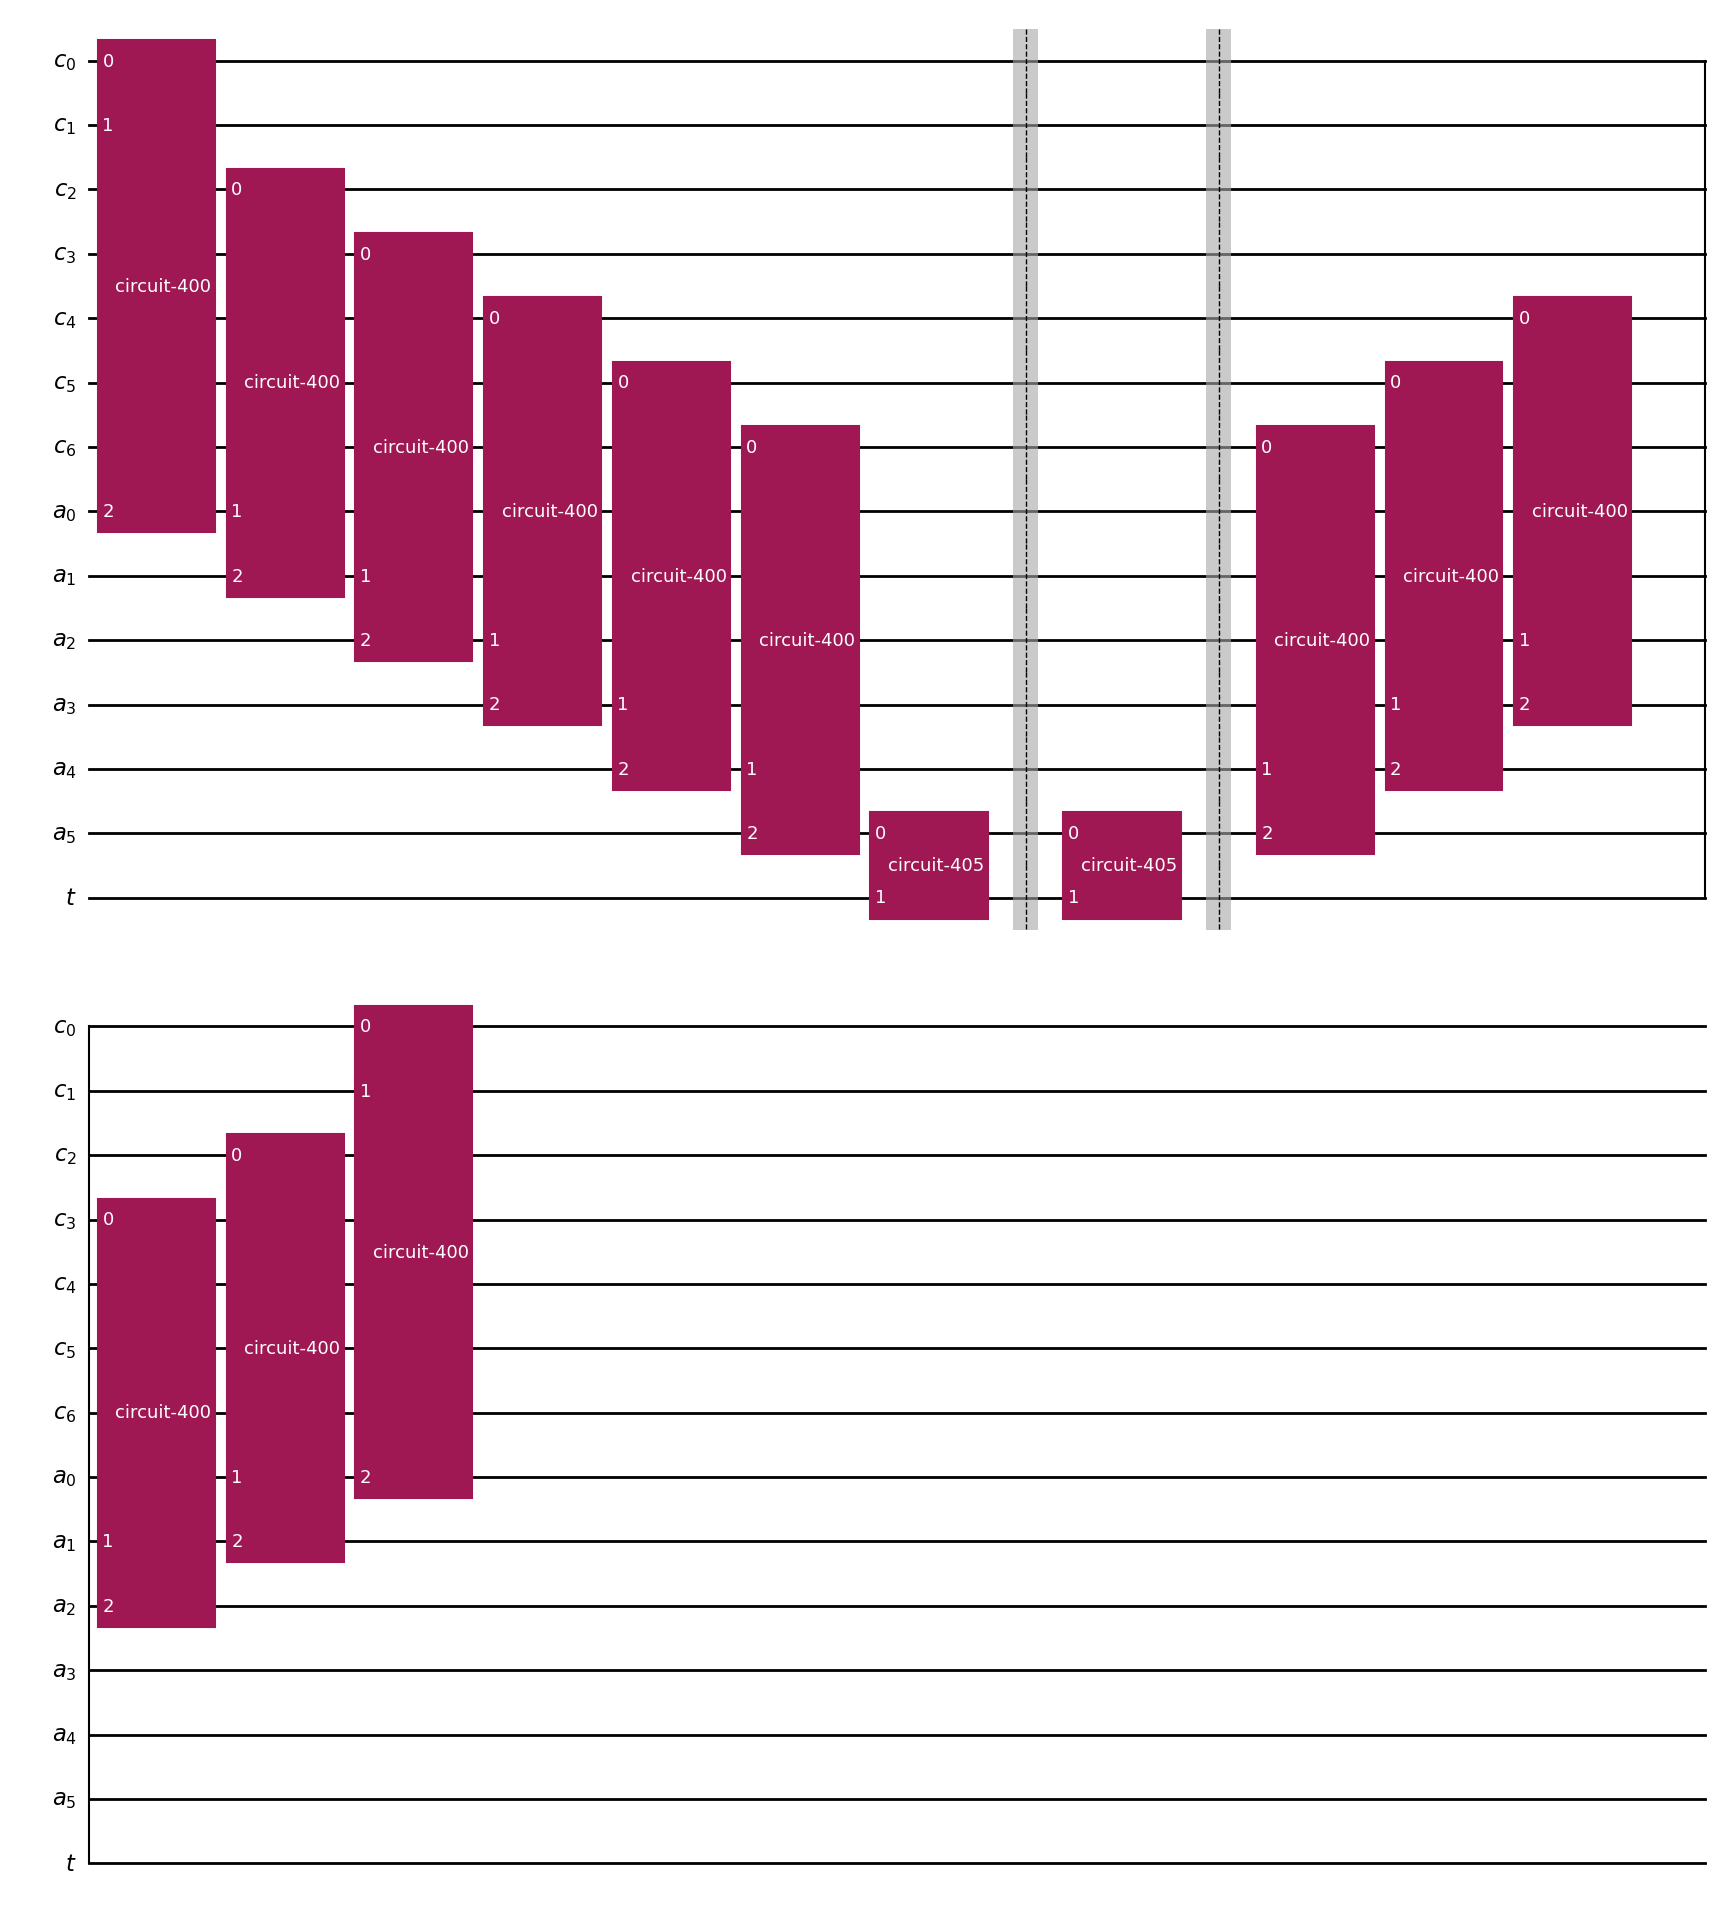

In [131]:
# Set some specific values for n and U

n=7
Theta = np.pi 
Phi = np.pi
Lam = 0
U = np.array([[np.cos(Theta/2), -np.exp(1j*Lam)*np.sin(Theta/2)], [np.exp(1j*Phi)*np.sin(Theta/2),np.exp(1j*(Phi+Lam))*np.cos(Theta/2)]])
qc = multi_controlled_u(n, U)

# Draw the circuit 
qc.draw('mpl')

A less ideal version of the above function is the following. 

In [132]:
def multi_controlled_v2(n, U):
    
# Check that n is a positive integer    
    if type(n) != int or n <= 0:
        return False
        
# Check that U is 2 by 2 unitary        
    if U.shape != (2, 2):
        return False
    if np.absolute(U[0,0]) != np.absolute(U[1,1]) or np.absolute(U[0,1]) != np.absolute(U[1,0]):
        return False
# Determine Theta, Phi and Lam from entries of U
    
    if np.isreal(U[0,0]) == True and -1<= U[0,0] <=1: 
        Theta = 2*np.arccos(U[0, 0])
        if np.sin(Theta/2) != 0:
            Lam = np.angle(-U[0, 1]/(np.sin(Theta/2)))
            Phi = np.angle(U[1, 0]/(np.sin(Theta/2)))
        else: 
            Phi = 0
            if U[0,1] != 0 or U[1,0] != 0:
                return False
            if U[0,0] == 0:
                return False   
            elif U[0,0] != 0:   
                Lam = U[1,1]/U[0,0]     
        
# Check that these parameters are set correctly
    
    if np.e**(1j*Lam)*np.e**(1j*Phi)* U[0,0] != U[1,1]:
        return False
        
# Handle the case n=1 
    if n == 1: 
        quantum_register = QuantumRegister(size=2, name="q")
        c_n_u_circuit = QuantumCircuit(quantum_register)
        # apply C
        c_n_u_circuit.rz((Lam-Phi)/2,quantum_register[1])
        # apply control gate
        c_n_u_circuit.cx(quantum_register[0],quantum_register[1])
        # apply B
        c_n_u_circuit.rz((-Lam-Phi)/2,quantum_register[1])
        angle = (-Theta / 2).real
        c_n_u_circuit.ry(angle,quantum_register[1])
        # apply control gate
        c_n_u_circuit.cx(quantum_register[0],quantum_register[1])
        # apply A
        c_n_u_circuit.ry(-angle,quantum_register[1])
        c_n_u_circuit.rz(Phi,quantum_register[1])
        # apply phase gate to qubit zero
        c_n_u_circuit.p((-Lam-Phi)/2, quantum_register[0])
    
# Handle the case n>1 
    if n >= 2: 
        quantum_register = QuantumRegister(n, name = "c")
        ancilla_register = AncillaRegister(n-1, name = "a")
        target_register = QuantumRegister(1, name = "t")
        c_n_u_circuit = QuantumCircuit(quantum_register, ancilla_register, target_register)
        
# Add an equivalent of the Toffoli gate  
# First, add the left-most Toffoli separately
        c_n_u_circuit.ccx(quantum_register[0],quantum_register[1],ancilla_register[0])

# Then add other Toffolis where the 2nd control and the target are ancillas
        for idx in range(2, n):
            c_n_u_circuit.ccx(quantum_register[idx],ancilla_register[idx-2],ancilla_register[idx-1])

# Implement a C^1 U gate 
        cu_gate = UGate(Theta, Phi, Lam).control(1)

        c_n_u_circuit.barrier()
# Add a CU gate between ancilla_register[3] and the target qubit 
        c_n_u_circuit.append(cu_gate, [ancilla_register[n-2], target_register[0]])

        c_n_u_circuit.barrier()
# Add equivalent of Toffoli gates using the decomposition below
# First, add other Toffolis where the 2nd control and the target are ancillas        
        for idx in reversed(range(2, n)):
            c_n_u_circuit.ccx(quantum_register[idx],ancilla_register[idx-2],ancilla_register[idx-1])
# Then add the right-most Toffoli separately
        c_n_u_circuit.ccx(quantum_register[0],quantum_register[1],ancilla_register[0])

        
# Return the constructed circuit 
    return c_n_u_circuit    

The above function, multi_controlled_v2, uses Qiskit's Toffoli gate and also a controlled $U$ gate with one control. 

We now explain how to implement $C^1 U$ by using elementary gates. 

## Case n=1. $C^1 U$

It is known that any unitary $U$ in $U(2)$ can be written in the following form
$$U(\theta, \varphi, \lambda) = \begin{bmatrix} \cos \left( \tfrac{\theta}{2} \right) & - e^{i \lambda} \sin \left( \tfrac{\theta}{2} \right) 
\\ e^{i \varphi} \sin \left( \tfrac{\theta}{2} \right) & e^{i (\varphi + \lambda)} \cos \left( \tfrac{\theta}{2} \right) \end{bmatrix} ,
$$
with three real-valued parameters $\theta, \varphi, \lambda$, except a possible phase factor of $e^{i\frac{\varphi+\lambda}{2}}$. This is the same as the expression for ([$U$ gate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UGate)) in Qiskit documentation. 

If $U$ is a $1$-qubit gate, then the controlled version of $U$, denoted by $C^1 U$, is the following 2-qubit gate:

$$C^1U \ket{x}\ket{y} = \left\{ \begin{array}{ll} \ket{x} \ket{y}, 
& \textnormal{if } x = 0, \\ \ket{x} U \ket{y}, & \textnormal{if } x = 1. \end{array} \right.$$

The very first example of a controlled $U$ gate is the $CNOT$ gate, for which we have $U= X$. 

In order to relate $CNOT$ to the case of $C^1 Z$, note that $Z = HXH$ and the $C^1 Z$ gate can be obtained from $CNOT$ gate: $$CZ = (I \otimes H) CNOT (I\otimes H).$$

This can be seen from the expression $$ CNOT = \ket{0} \bra{0} \otimes I + \ket{1} \bra{1} \otimes X ,$$ and composing both sides of this equation with $I\otimes H$. 

The above equation for $CZ$ follows from the identities $Z= HXH$ and $H^2 = I$. 

For $C^1 Y$, we note the fact that $$C^1 Y = (I \otimes S) CNOT (I\otimes S^\dagger),$$ where $S$ is a phase gate with phase $\pi/2$ and $S^\dagger$ is its inverse. 

Similarly, this equation is a result of the identities $Y = S X S^\dagger$ and $S^\dagger S = I =S S^\dagger$.  

For more general $U \in SU(2)$, $C^1 U$ can in general be written as 
$$C^1 U = \ket{0} \bra{0} \otimes I + \ket{1} \bra{1}\otimes U .$$ 

To implement it, we use a decomposition of $U$ into separate rotation gates along $y, z$ axes.  

### Corollary 4.2 of Nielsen and Chuang.

Given $U\in U(2)$ as in the above, $$ U = e^{i\frac{-\varphi-\lambda}{2}}AXBXC \quad \text{with} \quad ABC = I,$$ where $$A= R_Z \left( \varphi \right) R_Y \left(\tfrac{\theta}{2}\right) , \quad  B=  R_Y \left(-\tfrac{\theta}{2}\right) R_Z \left(\tfrac{-\varphi-\lambda}{2}\right)  , 
\quad C =  R_Z \left(\tfrac{ \lambda -\varphi}{2} \right) .$$ 

This is implemented in the following circuit. 

In [133]:
# Create the register and the circuit:
quantum_register = QuantumRegister(size=2, name="q")
quantum_circuit = QuantumCircuit(quantum_register)

# apply C
quantum_circuit.rz((Lam-Phi)/2,quantum_register[1])

# apply control gate
quantum_circuit.cx(quantum_register[0],quantum_register[1])

# apply B
quantum_circuit.rz((-Lam-Phi)/2,quantum_register[1])
quantum_circuit.ry((-Theta)/2,quantum_register[1])

# apply control gate
quantum_circuit.cx(quantum_register[0],quantum_register[1])

# apply A
quantum_circuit.ry((Theta)/2,quantum_register[1])
quantum_circuit.rz(Phi,quantum_register[1])

# apply phase gate to qubit zero
quantum_circuit.p((-Lam-Phi)/2, quantum_register[0])

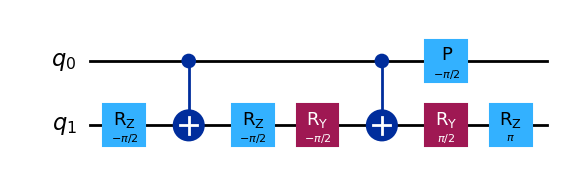

In [134]:
# Draw the above circuit.
quantum_circuit.draw(output='mpl')

We used $6$ phase gates and $2$ control gates here. This matches the number of gates we will obtain later for the implementation of $C^n U$ with general $n$, which is $30n-22$, and equals $8$ for $n=1$.

To explain why the above implements $C^1 U$, note that $(I\otimes A) (CNOT) (I\otimes B)(CNOT) (I\otimes C) \ket{11} = \ket{1} \otimes AXBXC\ket{1} = \ket{1}\otimes U\ket{1}$.

For other states $\ket{xy}$, $(I\otimes A) (CNOT) (I\otimes B)(CNOT) (I\otimes C) \ket{xy} = \ket{x} \otimes ABC\ket{y} = \ket{xy}$.

### Note. 

Upon a literature search, we find out that the above method for $n=1$ can be generalized to $n\geq 2$ as in [1], _Barenco et al_, Lemma 7.9 supposing an implementation of $C^{n-1} X$.

## Case $n =2$. $C^2 U$

We will need to use a unitary operator $V$ such that $V^2 = U$. Such operators can be found from Qiskit as follows. 

In [135]:
# Define the square root of U using the power method. 
V = UGate(Theta, Phi, Lam).power(1/2, annotated=True)

# Define the dagger/inverse of V.
V_dag = V.power(-1, annotated=True)

# Define the controlled V gate.
cv_gate = V.control(1, annotated=True)
cv_dag = V_dag.control(1, annotated=True)

The circuit will be the following.

In [136]:
# Create the register and the circuit:
quantum_register = QuantumRegister(size=3, name="q")
quantum_circuit = QuantumCircuit(quantum_register)
# Add controlled V gate [1,2]
quantum_circuit.append(cv_gate, quantum_register[1:3])
# Add control gate [0,1]
quantum_circuit.cx(quantum_register[0],quantum_register[1])
# Add controlled V_dag gate [1,2]
quantum_circuit.append(cv_dag, quantum_register[1:3])
# Add control gate [0,1] again
quantum_circuit.cx(quantum_register[0],quantum_register[1])
# Add controlled V gate [0,2]
quantum_circuit.append(cv_gate, quantum_register[1:3])

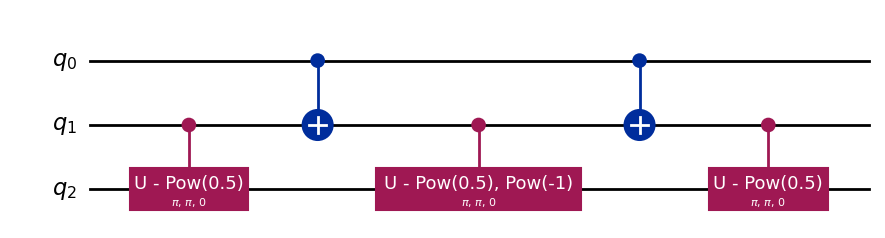

In [137]:
# Draw the circuit
quantum_circuit.draw(output='mpl')

## Case $n\geq 3$. $C^n U$

We apply the construction in Figure 4.10 of Nielsen and Chuang's book, _Quantum Computation and Quantum Information_.

The figure mentioned only involves the Toffoli gate $CCX$ and $C^1 U$ gate. 

### Note.

One can also use the case $n=2$ above and take $U$ to be the $X$-gate to implement the Toffoli gate. Indeed, Qiskit has a sqrtX gate ready to use. Thus, such a Toffoli gate implementation would require 4 gates if one uses the capabilities of Qiskit.

## Demonstrative example. $C^5 U$


In [138]:
# 5 control qubits, 1 target qubit, and 5 ancilla qubits in ket 0 state 

quantum_register = QuantumRegister(5, name = "c")
ancilla_register = AncillaRegister(4, name = "a")
target_register = QuantumRegister(1, name = "t")
quantum_circuit = QuantumCircuit(quantum_register, ancilla_register, target_register, name="n=5 circuit")

# Add Toffoli gates

quantum_circuit.ccx(quantum_register[0],quantum_register[1],ancilla_register[0])
quantum_circuit.ccx(quantum_register[2],ancilla_register[0],ancilla_register[1])
quantum_circuit.ccx(quantum_register[3],ancilla_register[1],ancilla_register[2])
quantum_circuit.ccx(quantum_register[4],ancilla_register[2],ancilla_register[3])

# Define a CU gate with one control 

cu_gate = UGate(Theta, Phi, Lam).control(1)

# Add a CU gate between ancilla_register[3] and the target qubit

quantum_circuit.append(cu_gate, [ancilla_register[3], target_register[0]])
quantum_circuit.ccx(quantum_register[4],ancilla_register[2],ancilla_register[3])
quantum_circuit.ccx(quantum_register[3],ancilla_register[1],ancilla_register[2])
quantum_circuit.ccx(quantum_register[2],ancilla_register[0],ancilla_register[1])
quantum_circuit.ccx(quantum_register[0],quantum_register[1],ancilla_register[0])


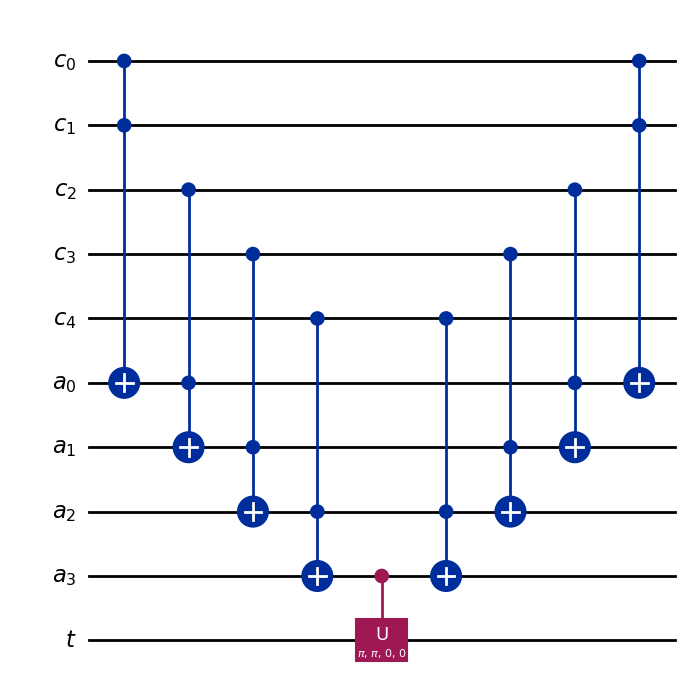

In [139]:
# Draw the circuit 
quantum_circuit.draw('mpl')

Therefore, in the case $n=5$, the implementation requires $8$ Toffoli gates and one $CU$ gate. From the above case for $n=1$,  we know that implementation of $CU$ gate requires $6$ phase gates and $2$ control gates. 

## Explanation.
The above circuit implements $C^5 U$, since if all the registry qubits are in state $\ket{1}$, then the ancilla qubits will be switched to $\ket{1}$ as well and $CU$ will apply. The second half of the circuit then switches the work qubits back to state $\ket{0}$. 

Otherwise, at least one registry qubit is in state $\ket{0}$. Noticing that all registry qubits are connected to at least one ancilla qubit, the ancilla qubits will remain in their original state $\ket{0}$. Therefore, all other states $\ket{x_4 x_3 x_2 x_1 x_0}$ will remain unchanged.


## Cost analysis.

The circuit in our function _multi_controlled_u(n)_ uses $15*2*(n-1)+8.1=30n-22$ gates, so the cost is $O(n)$ in terms of the gates. 

We also needed $n$ qubits in the register, $n-1$ ancilla qubits and $1$ qubit in the target register. Thus, the depth of the circuit is also $O(n)$.

### Note. Qiskit's implementation of $C^1 U$

We can also directly implement $C^1 U$ on Qiskit as follows. 

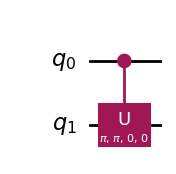

In [140]:
# Add controlled U gate to a circuit:
from qiskit.circuit.library.standard_gates import UGate
quantum_register = QuantumRegister(2, name = 'q')
quantum_circuit = QuantumCircuit(quantum_register)
cu_gate = UGate(Theta, Phi, Lam).control(1)
quantum_circuit.append(cu_gate, quantum_register)
quantum_circuit.draw('mpl')

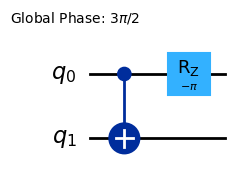

In [141]:
# We check the decomposition provided by Qiskit. 
decomposed_quantum_circuit = transpile(quantum_circuit, basis_gates = ['rx', 'ry', 'rz', 'cx'])
decomposed_quantum_circuit.draw('mpl')

Note that this used 11 phase gates and 2 control gates, whereas the function _multi_controlled_u(n)_ uses $8$.

### Note. Qiskit's implementation of $C^5 U$

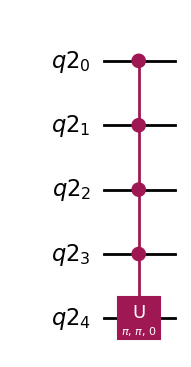

In [142]:
c_5_u_gate = UGate(Theta, Phi, Lam).control(4)
qr = QuantumRegister(5)
qc = QuantumCircuit(qr)
qc.append(c_5_u_gate, qr)
qc.draw('mpl')

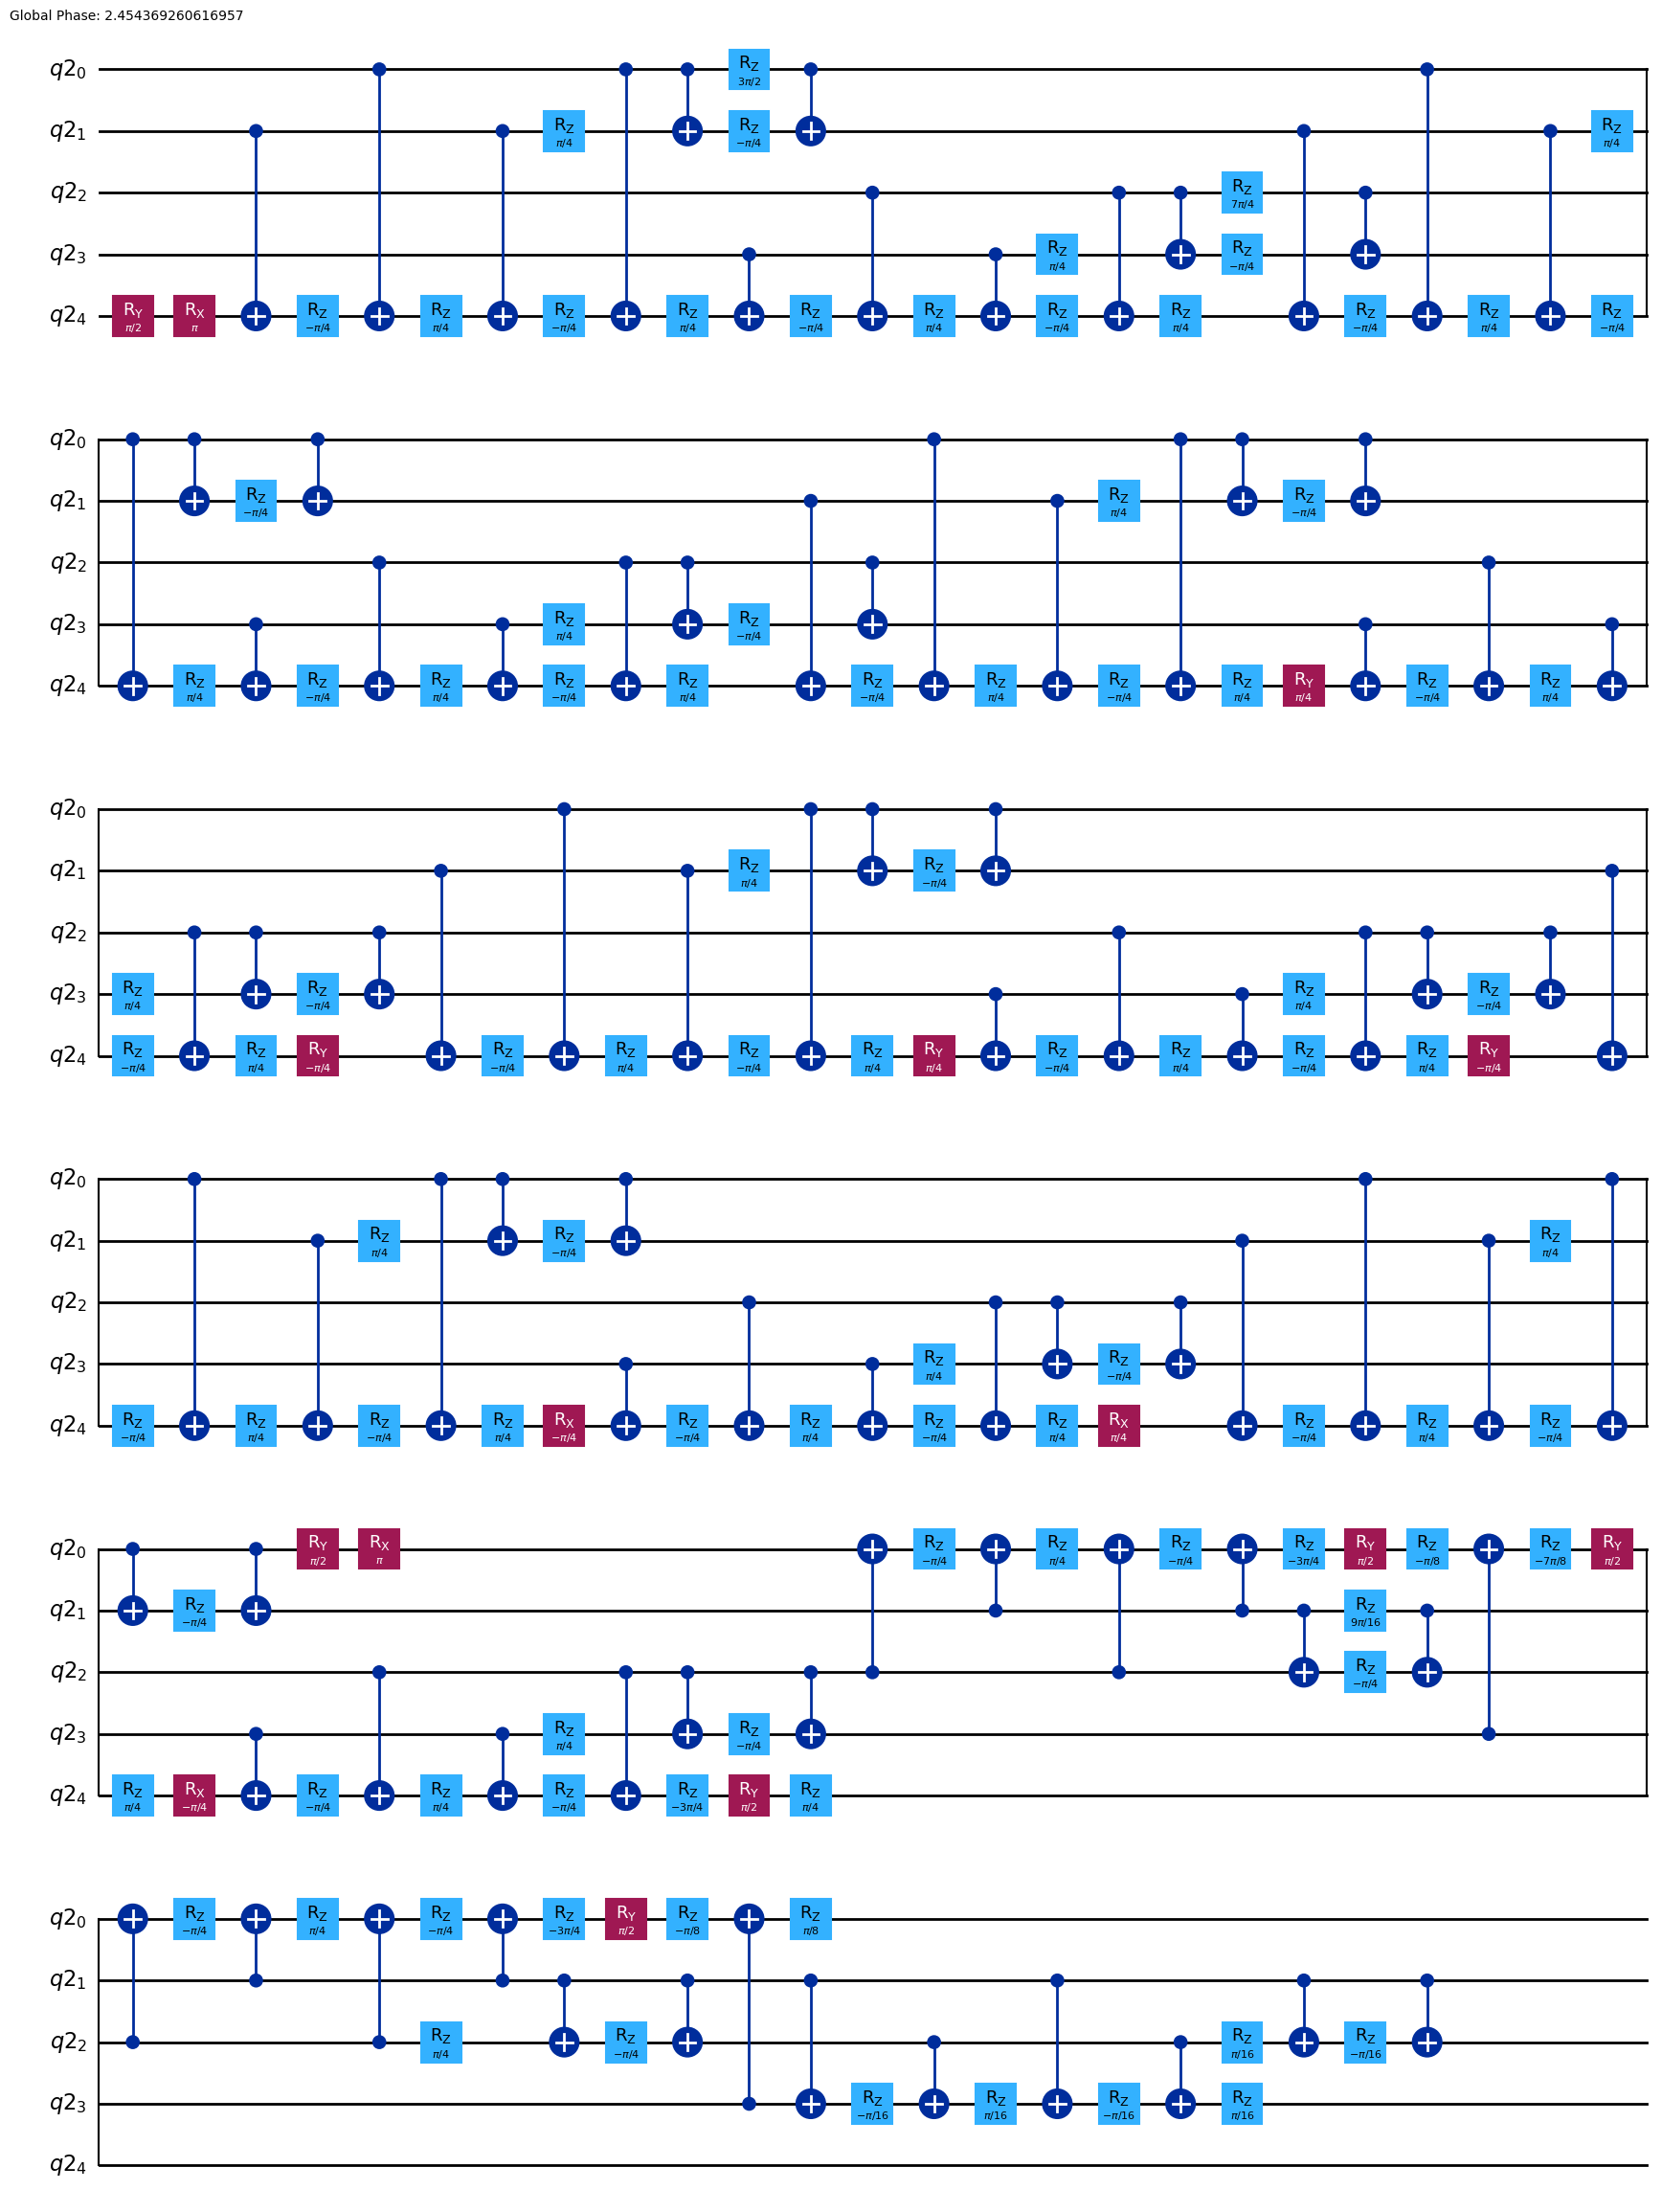

In [143]:
# Check the decomposition provided by Qiskit. 

decomposed_qc = transpile(qc, basis_gates = ['rx', 'ry', 'rz', 'cx'])
decomposed_qc.draw('mpl')

In [144]:
# Check the number of gates and the depth for the above circuit.

print(dict(decomposed_qc.count_ops()))
print(decomposed_qc.depth())

{'rz': 97, 'cx': 92, 'ry': 10, 'rx': 5}
142


The above circuit contains $92$ control gates and $151$ phase gates, so 243 gates in total, and it has depth $181$, whereas the function _multi_controlled_u(n)_ proposed has depth $10$ and it requires $128$ such single qubit gates.

## Other implementations in the literature. 

In [1], Corollary 7.6, Barenco et al. provided an implementation of $C^nU$ with $O(n^2)$ gates. 

In [2], Silva and Park introduced an implementation on a circuit with depth $O(n)$ that has $O(n^2)$ gates involving $2^n$th roots of the U gate in addition to controlled phase gates $C^k R_x(\pi)$ for $k<n-1$.

More recently, in [4], Theorem 1, Zindorf and Bose proposed an implementation of $C^n U$ for $n\geq 6$. This needed no ancillas, but 8 $R$ gates, $O(n)$ many CNOT, T and H gates, and it has depth $O(n)$. 

## References.

**1.** [Barenco et al] A. Barenco, C. H. Bennett, R. Cleve, D. P. DiVincenzo, N. Margolus, P. Shor, T. Sleator, J. A. Smolin, and H. Weinfurter, Elementary gates for quantum computation. Phys. Rev. A 52, 3457 (1995).

**2.** [Nielsen Chuang] M. Nielsen and I. Chuang, Quantum Computing and Quantum Information, Cambridge University Press, 10th anniversary edition.

**3.** [Silva Park] A. J. da Silva and D. K. Park, Linear-depth quantum circuits for multiqubit controlled gates, Phys. Rev. A 106, 042602.  
doi:(https://doi.org/10.1103/PhysRevA.106.042602)

**4.** [Zindorf Bose] B. Zindorf and S. Bose, Efficient Implementation of Multi-Controlled Quantum Gates, [arXiv](https://arxiv.org/pdf/2404.02279)

## Warning.

We had to use annotated operations by adding 'annotated=True' in implementing controlled and power versions of the $U$ gate with unassigned parameter values. Otherwise, the error message

_TypeError: ParameterExpression with unbound parameters (dict_keys([Parameter($\theta$)])) cannot be cast to a float_

appears. See the discussion about this on [this page](https://github.com/Qiskit/qiskit/pull/12752).
